In [1]:
import os
import logging


from wordcloud import WordCloud

from chirho.robust.handlers.predictive import PredictiveModel
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

import seaborn as sns
import numpy as np
from typing import List, Tuple, Dict, Any, Union
import matplotlib.pyplot as plt
import dill
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive

smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 2000

from cities.utils.data_grabber import find_repo_root
root = find_repo_root()

full zoning dataset within the period 410
after dropping university 326
154


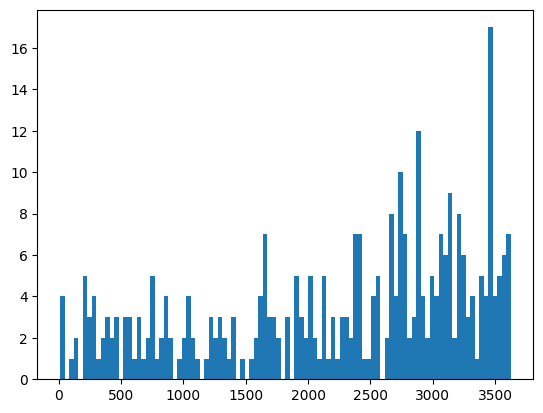

In [2]:
zoning_raw = pd.read_csv(os.path.join(root,"data/minneapolis/sourced/per_unit_parking.csv"))


#drop project name, address
zoning = zoning_raw.drop(columns=["project_name","address"])

# check nas
nas = zoning.isna().sum()
assert nas.sum() == 0


zoning['date'] = pd.to_datetime(zoning['date'])
start_date = pd.to_datetime('2011-01-01')

zoning['year'] = zoning['date'].dt.year
zoning['year_id'] = pd.factorize(zoning['year'])[0]

#drop year > 2020
zoning = zoning[zoning['year'] <= 2020]

#drop university of minnesota
print("full zoning dataset within the period", len(zoning))
zoning = zoning[zoning['university_yn'] == False]
print("after dropping university", len(zoning)) 


zoning['month'] = zoning['date'].dt.month
zoning['day']  = (zoning['date'] - start_date).dt.days


plt.hist(zoning['day'], bins=100) #note not only within-permit limits but also numbers of permissions is important
# and that the number of permissions is not stationary

print(len(zoning['day'].unique())) # note it seems like there have been 153 days with updates,
                                   # reason to believe that the data is not really daily


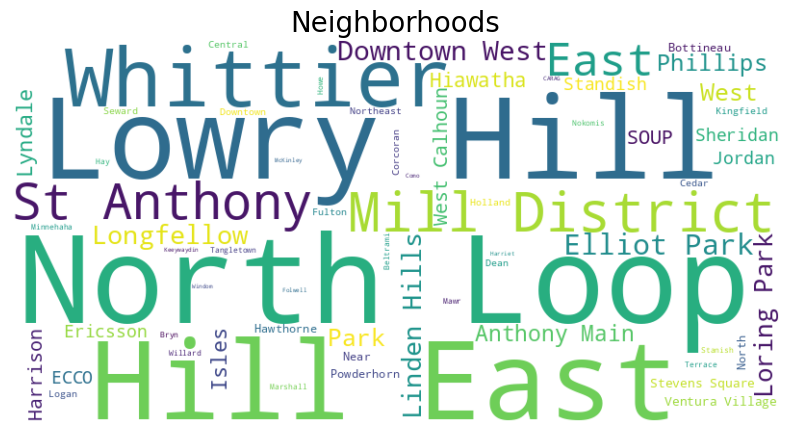

0.7116564417177914


In [3]:
# wordcloud to quickly check for typos
text = ' '.join(zoning['neighborhood'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neighborhoods', fontsize=20)
plt.show()

# note: neighborhoods might be important, perhaps partially because causally related to parcel size?

# parking reform was passed: July 10, 2015
reform = pd.to_datetime('2015-07-10')
reform_day = (reform - start_date).days

zoning['past_reform'] = zoning['date'] > reform

print(
zoning['past_reform'].mean()
#note 71 % permits are after the reform
)



limit
eliminated    190
full           82
reduced        54
Name: count, dtype: int64
neigh [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
wards [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


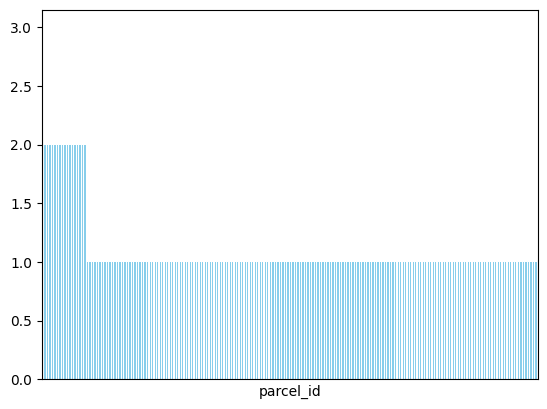

In [4]:

criteria = ['past_reform', 'res_parking_elim_2015_yn', 'res_parking_reduced_2015_yn']

replacement_dict = {
    'FalseFalseFalse': 'full',
    'FalseTrueFalse': 'full',
    'FalseFalseTrue': 'full',
    'FalseTrueTrue': 'full',
    'TrueFalseFalse': 'full',
    'TrueTrueFalse': 'eliminated',
    'TrueFalseTrue': 'reduced',
    'TrueTrueTrue': 'eliminated' 
}

zoning['limit'] = zoning[criteria].astype(str).agg(''.join, axis=1).replace(replacement_dict)

zoning.loc[zoning['downtown_yn'], 'limit'] = 'eliminated'

limit_ordering = ['eliminated', 'reduced', 'full']

zoning['limit'] = pd.Categorical(zoning['limit'], categories=limit_ordering, ordered=True)

zoning['limit_id'] = zoning['limit'].cat.codes

#sanity check
print(zoning['limit'].value_counts())



columns_to_factorize = ['year', 'month', 'day', 'neighborhood', 'ward']

for column in columns_to_factorize:
    zoning[column + '_id'] = pd.factorize(zoning[column])[0]



print("neigh", zoning['neighborhood_id'].unique() )
print("wards", zoning['ward_id'].unique() )
# 76 neighborhoods, 13 wards


# note one or two permits per parcel, no strong reason to use parcels as units of analysis
zoning['parcel_id'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks([])
plt.show()


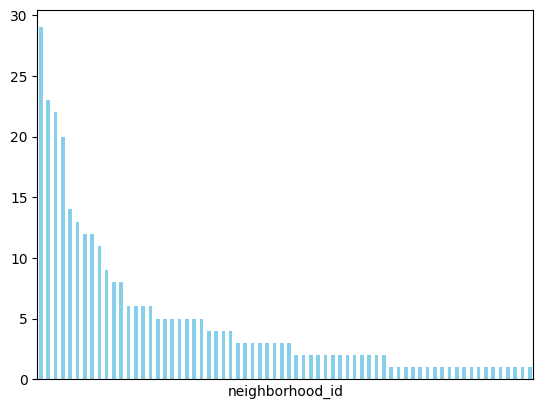

,parcel_id,date,neighborhood,ward,downtown_yn,housing_units,car_parking,bike_parking,parcel_area,university_yn,...,past_reform,limit,limit_id,month_id,day_id,neighborhood_id,ward_id,housing_units_std,car_parking_std,parcel_area_std
0,2602924310063,2011-01-10,Elliot Park,6,True,7,0,0,7245.893155,False,...,False,eliminated,0,0,0,0,0,-0.893078,-0.821149,-0.621041
1,102824440106,2011-01-10,Stanish Ericsson,12,False,64,74,80,38210.631831,False,...,False,full,2,0,0,1,1,-0.338982,-0.111109,0.011602
2,2702924430325,2011-01-10,Stevens Square,6,False,123,104,62,73747.490123,False,...,False,full,2,0,0,2,0,0.234556,0.176745,0.737659
3,3302924440363,2011-02-07,Lowry Hill East,10,False,198,240,108,70847.105465,False,...,False,full,2,1,1,3,2,0.963630,1.481683,0.678401
5,1702823340059,2011-04-11,Nokomis East,12,False,42,42,21,52590.828770,False,...,False,full,2,2,2,4,1,-0.552844,-0.418154,0.305405


In [5]:

# we might have a shot with neighborhoods as units of analysis
zoning['neighborhood_id'].value_counts().plot(kind='bar', color='skyblue')
plt.xticks([])
plt.show()


columns_to_standardize = ['housing_units', 'car_parking', 'parcel_area']

for column in columns_to_standardize:
    zoning[column + '_std'] = (zoning[column] - zoning[column].mean()) / zoning[column].std()

display(zoning.head())


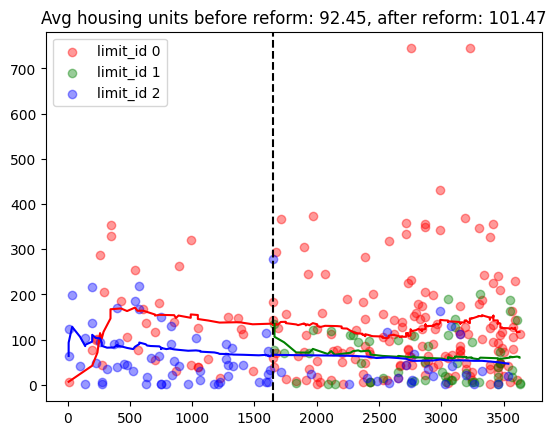

In [6]:
window_size = 60

rolling_avgs = {}
for limit_id, group in zoning.groupby('limit_id'):
    rolling_avgs[limit_id] = group['housing_units'].rolling(window_size, min_periods=1).mean()

rolling_total = zoning['housing_units'].rolling(window_size, min_periods=1).sum()
rolling_avg = zoning['housing_units'].rolling(window_size, min_periods=1).mean()


for limit_id, color in enumerate(['red', 'green', 'blue']):
    plt.scatter(x=zoning[zoning['limit_id'] == limit_id]['day'], y=zoning[zoning['limit_id'] == limit_id]['housing_units'],
                alpha=0.4, c=color, label=f'limit_id {limit_id}')
    plt.plot(zoning[zoning['limit_id'] == limit_id]['day'], rolling_avgs[limit_id], c=color)

plt.axvline(reform_day, color='black', linestyle='--')

# possibly plot running total sum, seems to be an increase after the reform
#plt.plot(zoning['day'], rolling_total, c='black', label='total', linestyle='--')

#possibly plot running average
# average permit size does not increase too much
#plt.plot(zoning['day'], rolling_avg, c='black', label='total', linestyle='--')

# average before reform
avg_before = zoning[zoning['day'] < reform_day]['housing_units'].mean()
avg_after = zoning[zoning['day'] >= reform_day]['housing_units'].mean()

plt.title(f'Avg housing units before reform: {avg_before:.2f}, after reform: {avg_after:.2f}')
plt.legend()
plt.show()

# note the red line doesn't have to upwards to show that the lower limits have effect

# also: think hard what it is that we care about trying to predict, there are many ways to conceptualize the problem

# for now, the question we're trying to aswer is: what is the effect of limit class on the number of housing units

In [7]:
# tensor prep

housing_units = torch.tensor(zoning['housing_units_std'].values, dtype=torch.float)

parcel_area = torch.tensor(zoning['parcel_area_std'].values, dtype=torch.float)

limit_id = torch.tensor(zoning['limit_id'].values, dtype=torch.long)
neighborhood_id = torch.tensor(zoning['neighborhood_id'].values, dtype=torch.long)

outcome = housing_units

categorical = {'limit_id': limit_id,
               'neighborhood_id': neighborhood_id}

continuous = {"parcel_area": parcel_area} #with an eye on generality


In [8]:
#TODO refactor to make less messy and 
# to allow for easy use of Predictive on other data

class SimpleLinear(pyro.nn.PyroModule):
    def __init__(self, categorical: Dict[str,torch.Tensor], 
                continuous: Dict[str,torch.Tensor], outcome: torch.Tensor,
                categorical_levels: Dict[str,torch.Tensor] = None,

                leeway = .9 ):
        super().__init__()

        # move away from init to allow for easy use of Predictive on other data

        self.leeway = leeway
        
        self.N_categorical = len(categorical.keys())

        if self.N_categorical > 0 and categorical_levels is None:
            self.categorical_levels = dict()
            for name in categorical.keys():
                self.categorical_levels[name] = (torch.unique(categorical[name]))

        
        self.N_continuous = len(continuous.keys()) 




        # if categorical:
        #     self.categorical = categorical
        #     self.categorical_names = list(categorical.keys())
        #     self.categorical_stacked = torch.stack(list(categorical.values()), dim=0)
            
        # self.N_categorical = len(categorical.keys())


        # if continuous:
        #     self.continuous = continuous
        #     self.continuous_names = list(continuous.keys())
        #     self.continuous_stacked = torch.stack(list(continuous.values()), dim=0)
        
        # self.N_continuous = len(continuous.keys())  

        # self.outcome = outcome
        
        # self.n = len(outcome)
        

    # TODO no major causal assumptions are added
    # TODO add year/month latents
    # TODO add neighborhood latents as impacting parcel areas and limits     
   

    # arguments here intentionally to facilitate Predictive with data not used for training
    # TODO streamline this
    def forward(self, categorical: Dict[str,torch.Tensor], 
                continuous: Dict[str,torch.Tensor],
                outcome: torch.Tensor = None,
                categorical_levels: Dict[str,torch.Tensor] = None,
                leeway = .9):
    

        n = len(outcome)

        if categorical_levels is None:
            categorical_levels = self.categorical_levels
        
 

        sigma_outcome = pyro.sample("sigma", dist.Exponential(1.))

        data_plate = pyro.plate("data", size=n, dim=-1)

        running_dim =  -2

        # ___________________________________________________________________________________________________
        # add a plate and linear connection to outcome for categorical variables if any
        if self.N_categorical >0:
            
            categorical_plate = pyro.plate("categorical_nuisance", size=self.N_categorical, dim=running_dim)
            running_dim -= 1
        
            with categorical_plate:
                bias_categorical = pyro.sample("bias_categorical", dist.Normal(0., self.leeway))


        # Predictive doesn't seem to inherit much of the init matters
            categorical_names = list(categorical.keys())
            categorical_levels = dict()
            for name in categorical_names:
                categorical_levels[name] = (torch.unique(categorical[name]))


            weights_categorical = dict()
            
            for name in categorical_names:
                with pyro.plate(f"w_plate_{name}", size=len(categorical_levels[name]), dim=(running_dim)):
                    weights_categorical[name] = pyro.sample(f"weights_categorical_{name}", dist.Normal(0., self.leeway))
                running_dim -= 1

            with data_plate:

                categorical_contribution = torch.zeros(1, 1, 1, len(outcome))
                for name in categorical.keys():
                    while weights_categorical[name].shape[-1] == 1:
                        weights_categorical[name] = weights_categorical[name].squeeze(-1)
                
                categorical_contribution = torch.einsum("...d, ...d -> ...d", categorical_contribution, 
                                          torch.einsum("...d -> ...d", 
                                                weights_categorical[name][...,categorical[name]]))  
    
    #_____________________________________________________________________________________________________
    # same for continuous variables

        if self.N_continuous>0:

            continuous_stacked = torch.stack(list(continuous.values()), dim=0)

            with pyro.plate("continuous", size = self.N_continuous , dim=running_dim):
                bias_continuous = pyro.sample("bias_continuous", dist.Normal(0., self.leeway))
                weight_continuous_outcome = pyro.sample("weight_continuous", dist.Normal(0., self.leeway))
        
    
            running_dim -= 1

            with data_plate:

                continuous_contribution = torch.einsum("cd, c... -> ...d", continuous_stacked,
                                                        weight_continuous_outcome)
                
    # ___________________________________________________________________________________                
    # linear model for outcome

        with data_plate:
            mean_outcome_prediction = pyro.deterministic("mean_outcome_prediction", 
                (torch.einsum("...bd -> ...d", bias_categorical) + categorical_contribution) * (self.N_categorical > 0) +
                (torch.einsum("b...d -> ...d", bias_continuous) + continuous_contribution) * (self.N_continuous > 0),
                event_dim=0) 

            outcome_observed = pyro.sample("outcome_observed", 
                            dist.Normal(mean_outcome_prediction, sigma_outcome), obs = outcome)

simple_linear = SimpleLinear(categorical, continuous, outcome)


with pyro.poutine.trace() as tr:
    simple_linear(categorical, continuous, outcome)

for site in tr.trace.nodes.values():
    if site["type"] == "sample":
        print(site['name'], site['value'].shape)


sigma torch.Size([])
data torch.Size([326])
categorical_nuisance torch.Size([2])
bias_categorical torch.Size([2, 1])
w_plate_limit_id torch.Size([3])
weights_categorical_limit_id torch.Size([3, 1, 1])
w_plate_neighborhood_id torch.Size([68])
weights_categorical_neighborhood_id torch.Size([68, 1, 1, 1])
continuous torch.Size([1])
bias_continuous torch.Size([1, 1, 1, 1, 1])
weight_continuous torch.Size([1, 1, 1, 1, 1])
mean_outcome_prediction torch.Size([1, 1, 1, 1, 326])
outcome_observed torch.Size([326])


[iteration 0001] loss: 622.4645
[iteration 0050] loss: 517.1655
[iteration 0100] loss: 494.3222
[iteration 0150] loss: 466.7483
[iteration 0200] loss: 457.4026
[iteration 0250] loss: 444.9250
[iteration 0300] loss: 438.0636
[iteration 0350] loss: 442.6221
[iteration 0400] loss: 433.7994
[iteration 0450] loss: 439.5769
[iteration 0500] loss: 435.9334
[iteration 0550] loss: 436.1924
[iteration 0600] loss: 439.5817
[iteration 0650] loss: 433.0948
[iteration 0700] loss: 435.9205
[iteration 0750] loss: 435.0079
[iteration 0800] loss: 426.0130
[iteration 0850] loss: 434.2801
[iteration 0900] loss: 436.2199
[iteration 0950] loss: 438.1794
[iteration 1000] loss: 435.5776
[iteration 1050] loss: 434.7794
[iteration 1100] loss: 432.5306
[iteration 1150] loss: 437.6890
[iteration 1200] loss: 435.4524
[iteration 1250] loss: 435.0172
[iteration 1300] loss: 436.9171
[iteration 1350] loss: 432.9968
[iteration 1400] loss: 435.3910
[iteration 1450] loss: 435.0444
[iteration 1500] loss: 437.5714
[iterati

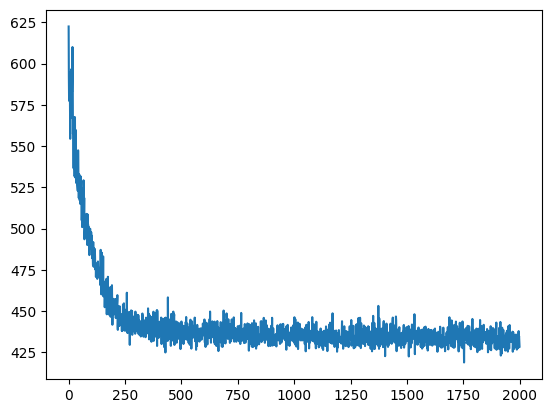

In [9]:
def run_svi_inference(
    model,
    n_steps=500,
    verbose=True,
    lr=0.03,
    vi_family=AutoMultivariateNormal,
    guide=None,
    **model_kwargs
):
    losses = []
    if guide is None:
        guide = vi_family(model, init_loc_fn=init_to_mean)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        losses.append(loss.item())
        adam.step()
        if (step % 50 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))

    plt.plot(losses)

    return guide


linear_model = SimpleLinear(categorical, continuous, outcome)

model_kwargs = {"categorical": categorical, "continuous": continuous, "outcome": outcome}

guide = run_svi_inference(
    linear_model, n_steps=n_steps, lr=0.01, verbose=True, **model_kwargs
)

In [10]:
predictive = Predictive(linear_model, guide=guide, num_samples=num_samples)

samples = predictive(categorical, continuous, outcome)

1000


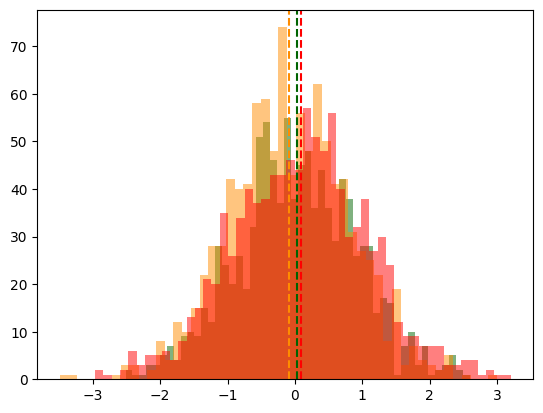

In [11]:
samples.keys()

limit_samples = samples['weights_categorical_limit_id'].squeeze()

limit_samples.shape

eliminated = limit_samples[:, 0]
reduced = limit_samples[:, 1]
full = limit_samples[:, 2]

print(len(eliminated))

plt.hist(eliminated, bins=50, alpha=0.5, color = "darkgreen", label='eliminated')
plt.hist(reduced, bins=50, alpha=0.5, color = "darkorange", label='reduced')
plt.hist(full, bins=50, alpha=0.5, color = "red", label='full')
# add colored lines for means
plt.axvline(eliminated.mean(), color='darkgreen', linestyle='--')
plt.axvline(reduced.mean(), color='darkorange', linestyle='--')
plt.axvline(full.mean(), color='red', linestyle='--')
plt.show()


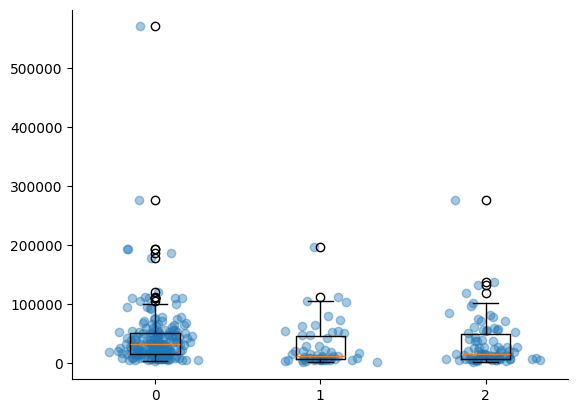

In [12]:
# plot parcel area vs. limit
jitter = np.random.normal(0, 0.1, size=len(zoning))
plt.scatter( y = zoning['parcel_area'] , x = zoning['limit_id'] + jitter, alpha=0.4)
plt.boxplot([zoning[zoning['limit_id'] == 0]['parcel_area'],
             zoning[zoning['limit_id'] == 1]['parcel_area'],
             zoning[zoning['limit_id'] == 2]['parcel_area']],
            positions=[0, 1, 2])
sns.despine()
plt.show()



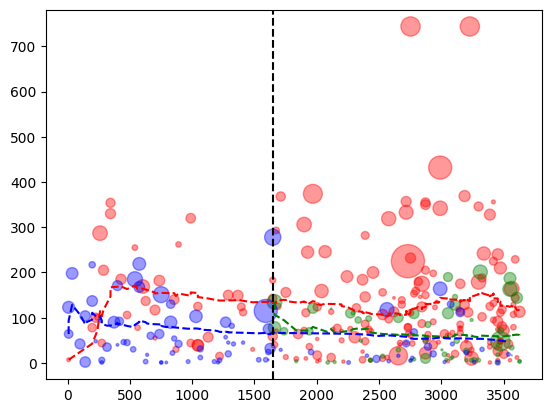

In [13]:
for limit_id, color in enumerate(['red', 'green', 'blue']):
    plt.scatter(x=zoning[zoning['limit_id'] == limit_id]['day'], y=zoning[zoning['limit_id'] == limit_id]['housing_units'],
                alpha=0.4, c=color, label=f'limit_id {limit_id}',
                s=zoning[zoning['limit_id'] == limit_id]['parcel_area'] * 1e-3)
    plt.plot(zoning[zoning['limit_id'] == limit_id]['day'], rolling_avgs[limit_id], c=color, linestyle='--')
plt.axvline(reform_day, color='black', linestyle='--')

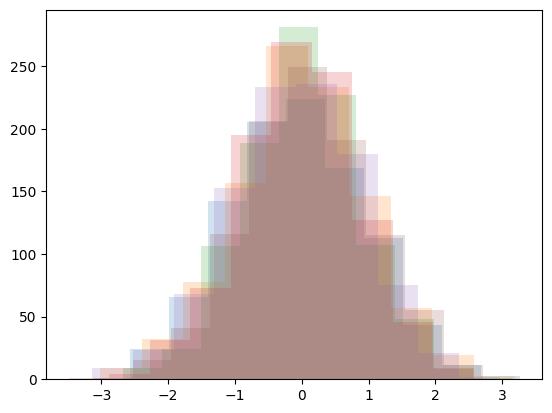

In [14]:
neighborhood_id_samples = samples['weights_categorical_neighborhood_id'].squeeze()
neighborhood_id_samples.shape

for i in [1,4,5, 23, 52, 65]:
    plt.hist(neighborhood_id_samples[:, i], alpha=0.2)

plt.show()


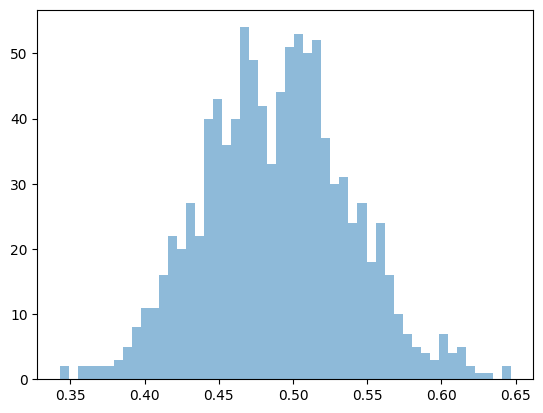

In [15]:
weight_parcel_area = samples['weight_continuous'].squeeze()

plt.hist(weight_parcel_area, bins=50, alpha=0.5)
plt.show()

In [18]:

#TODO allow for empty input groups
linear_model = SimpleLinear({'limit_id': categorical['limit_id']}, continuous = {}, outcome = outcome)

model_kwargs = {"categorical": {'limit_id': categorical['limit_id']}, "continuous": {}, "outcome": outcome}

guide = run_svi_inference(
    linear_model, n_steps=n_steps, lr=0.01, verbose=True, **model_kwargs
)

UnboundLocalError: local variable 'bias_continuous' referenced before assignment